In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate
import control as ct
from qpsolvers import cvxopt_solve_qp as solve_qp
from matplotlib import animation
from scipy import signal
import math
import cvxpy as cp

In [2]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Model
from keras.layers import Input, Layer, Dense, Dropout, Activation
from keras import backend as K
print(tf.__version__)
# # tf.compat.v1.enable_eager_execution()
# tf.executing_eagerly()
tf.compat.v1.disable_eager_execution()

2.6.0


In [3]:
N=1000
t=np.arange(N)*(1/4000)
Ts=1/4000

In [4]:
x_0=[0.1999]

In [5]:
def f (x):
    return 1.5*x

In [6]:
def g (x): 
    return 1

In [7]:
def hat_f (x):
    return x

In [8]:
phi=lambda x: 1-25*x**2

In [9]:
grad_phi=lambda x: -50*x

In [10]:
def u_nominal (x):       #We may not use this
    return -x

In [11]:
#Hyperparameters   #For now ignore these too! Please do not delete these.

theta=0.1
margin=0.07
correction_strength=4
#alpha=10

In [12]:

U=np.zeros(N)
S=np.zeros(N)
Dot_X=np.zeros(N)
Y=np.zeros(N)
last_u=0
#last_u=u_nominal(x_0)
global_state=0
global_u=0
#global_timer=0
count=0
m=0
s=0

In [13]:
# Bayesian neural networks
class NegativeLogLikelihood(Layer):
	def call(self, inputs):
		y_pred_mean = inputs[0]
		y_pred_var = inputs[1]
		y_true = inputs[2]
		loss = K.sum(K.log(y_pred_var+K.epsilon())+K.square(y_pred_mean-y_true) / y_pred_var,axis=-1)
		return loss

def identity_loss(y_true, loss):
	return loss

class VanillaNN:
	def __init__(self,xdim,ydim):
		input_x = Input(shape=(xdim,), dtype='float', name='input_x')
		x = Dense(256, activation='tanh')(input_x)
		x = Dropout(0.5)(x)
		x = Dense(256, activation='tanh')(x)
		x = Dropout(0.5)(x)
		x = Dense(256, activation='tanh')(x)
		x = Dropout(0.5)(x)
		x = Dense(256, activation='tanh')(x)
		output_mean = Dense(ydim, activation='linear', name='output_mean')(x)
		output_var = Dense(ydim, activation='softplus', name='output_var')(x)
		input_y = Input(shape=(ydim,), dtype='float', name='input_y')
		output_loss = NegativeLogLikelihood()([output_mean,output_var,input_y])

		self.m = Model(inputs=[input_x,input_y], outputs=[output_mean,output_var,output_loss])
		rmsprop = tf.keras.optimizers.RMSprop(learning_rate=0.001, rho=0.9, epsilon=None, decay=0.0)
		self.m.compile(loss=identity_loss, loss_weights=[0., 0., 1.], optimizer=rmsprop)
		# self.m.run_eagerly = True
		# self.m.compile(run_eagerly=True)
		# tf.compat.v1.enable_eager_execution()
		self.graph = tf.compat.v1.get_default_graph()
	  

	def train(self, Z_train, Y_train,_epoch=50,_batch_size=64,_verbose=0):
		with self.graph.as_default():
			self.m.fit([Z_train,Y_train], [Y_train,Y_train,Y_train],epochs=_epoch,batch_size=_batch_size,verbose=_verbose)

	def predict(self, ZN, Y, _batch_size=1):
		with self.graph.as_default():
			y, var, loss = self.m.predict([ZN,Y], batch_size=_batch_size)
		# print("Predicted y ", y)
		# print("predicted var ", var)
		# print("predicted loss ", loss)
		return y[0], var[0], loss[0]

In [14]:
def BALSA(x):
    
    global m
    global s
    
    x_dot_last_instance=Dot_X[count-1]  #Assuming continuous derivatives. Use this for line 11 of the algorithm, where
    # (x_2(t+dt)-x_2(t))/dt can be replaced by this variable.
    #Also please see the functions below, S[0:count-1], will give you access to all the past values of X_t for NN training.
    #Likewise U[0:count-1] and Dot_X[0:count-1] for all the past control and x_dot values.
    #Y[0:count-1] gives us all the past Y_t values for the neural network training.
    
    
    #When x_dot is continuous, x_dot_last_instance=f(x)+g(x)*u, even though we don't know f(x). So, we have:
    mu_pd=x_dot_last_instance-g(S[count-1])*U[count-1]+g(x)*u_nominal(x) 
    
    #The above mu_pd is then just f(x)+g(x)*u which a user with unknown f(x) can compute too!
    
    #So, without the mu_qp term for safety and assuming mu_ad is perfect, this should
    #lead to the dynamics, x_dot=f(x)+g(x)u=0.5*x, which is exponentially increasing, leading the state variable into 
    #the unsafe regiom soon.
    
    #Below, we need to predict Y_t from X_t using a Neural Network.
    #Use all past data to train the network.
    #Now the trained NN model takes (x) as input and returns the value of corresponding y. 
    #The NN outputs a mean value m, and a standard deviation s.
    
    
    if(count%100==7):
    
        #Please implement the Neural Network and obtain the prediction (m,s) here.
    
    
        # train the dropout network
        #print('train begin...')
        xdim = S[0:count-1].ndim
        ydim = Y[0:count-1].ndim
        dropout_NN = VanillaNN(xdim, ydim)
        dropout_NN.train(Z_train = S[0:count-1], Y_train = Y[0:count-1])
        #print('train finish')
        
        # prediction
        #print('prediction...')
        y_bar, var, loss=dropout_NN.predict(S,Y)
        m = np.mean(y_bar)
        s = np.var(y_bar)
        #print(m,s)
        
    
    
    
    
    
    
    
    
    
    
    
    #end of if
    
    mu_ad=np.random.normal(m,s)
    
    
    
    
    #Next, we solve the QP to obtain the mu_qp term below. 
    # phi_0=grad_phi*mu_pd
    #phi_1=grad_phi
    
    #Then the qp is:
    # minimize mu_qp^2+5*d^2 
    # subject to:
    #      phi_0+phi_1*mu_qp >= d
    #                     d  <= 0
    
    #below we take y=[mu_qp,d].T in the quadratic program.
    
    phi0=grad_phi(x)*mu_pd
    phi1=grad_phi(x)
    y=cp.Variable(2)
    P=np.array([[2.0,0.0],[0.0,10.0]])
    q=np.array([0.0,0.0])
    G=np.array([[-phi1,1.0],[0.0,1.0]])
    h=np.array([phi0,0.0])
    A=np.array([0.0,0.0])
    b=np.array([0.0])
    prob = cp.Problem(cp.Minimize((1/2)*cp.quad_form(y, P) + q.T @ y),
                 [G @ y <= h,
                  A @ y == b])
    prob.solve()
    
    sol=y.value
    
    mu_qp=sol[0]
    
    
    
    
    
    
    
    #Once all the mu's are found we are done here.
    u=(1/g(x))*(mu_pd+mu_qp-mu_ad-hat_f(x))   #there is no mu_rm for us.
    return u

In [15]:
def play_dynamics(X):
    global count
    global last_u
    #u=u_nominal(X)
    u=BALSA(X)
    if (count < N):
        U[count]=u
        S[count]=X
        Dot_X[count]=f(X)+np.dot(g(X),u)
        Y[count]=Dot_X[count]-(hat_f(S[count])+g(S[count])*U[count])
        count=count+1
    return (f(X)+np.dot(g(X),u))

In [16]:
def dynamics_runner(x_0,t):
    d=t.shape[0]
    X_0=np.copy(x_0)
    X=x_0
    X=np.expand_dims(X_0,axis=0)
    #print(np.shape(X))
    dt=t[1]-t[0]
    for i in range(d):
        dX=dt*play_dynamics(X[i])
        #print(dX)
        X_n=X[i]+dX
        X=np.append(X,[X_n],axis=0)
    return X

In [17]:
X=dynamics_runner(x_0,t)

/Applications/anaconda3/envs/disparity/lib/python3.6/site-packages/ipykernel_launcher.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/Applications/anaconda3/envs/disparity/lib/python3.6/site-packages/ipykernel_launcher.py:84: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/Applications/anaconda3/envs/disparity/lib/python3.6/site-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Mode

In [18]:
phi_balsa=np.zeros(N)
for i in range(N):
    phi_balsa[i]=phi(S[i])

Text(0.5, 1.0, 'Barrier zeroing function $phi(X)$')

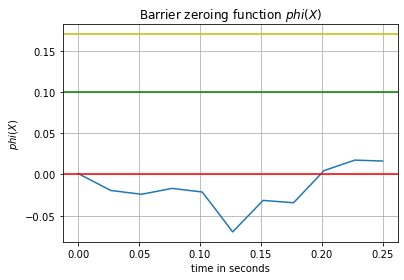

In [19]:
plt.figure()
plt.plot(t[0:N], phi_balsa[0:N]); plt.axhline(y = 0, c = 'r');plt.axhline(y=theta,c='g'); plt.axhline(y=theta+margin,c='y'); plt.grid()
plt.xlabel('time in seconds')
plt.ylabel('$phi(X)$')
plt.title('Barrier zeroing function $phi(X)$')

Text(0.5, 1.0, 'control variable norm dynamics')

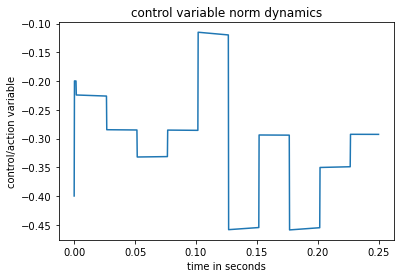

In [20]:
plt.figure()
#U_norm=np.linalg.norm(U,axis=0)
plt.plot(t[0:N],U[0:N])
plt.xlabel('time in seconds')
plt.ylabel('control/action variable')
plt.title('control variable norm dynamics')

Text(0.5, 1.0, 'state variable dynamics')

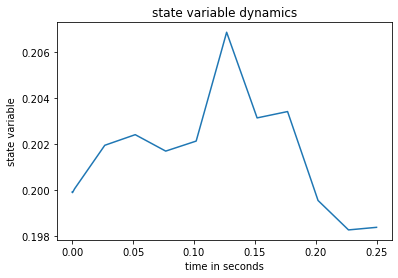

In [21]:
plt.figure()
#U_norm=np.linalg.norm(U,axis=0)
plt.plot(t[0:N],S[0:N])
plt.xlabel('time in seconds')
plt.ylabel('state variable')
plt.title('state variable dynamics')

In [22]:
%store phi_balsa

Stored 'phi_balsa' (ndarray)
